# End-to-end Learning: Pilotless Communications via Custom Constellation

The neural receiver (NRX) can be seen as an enabler for various novel features in wireless communications such as [site-specific receiver training](https://developer.nvidia.com/blog/towards-environment-specific-base-stations-ai-ml-driven-neural-5g-nr-multi-user-mimo-receiver/) or pilotless communications via end-to-end learning [[1]](#references). The core idea is that the combination of a neural receiver with a trainable custom constellation does not need to rely on any DMRS pilots for successful data reconstruction. This reduces the required piloting overhead and effectively increases the spectral efficiency of the end-to-end system.

In this notebook, we show that the NRX can be used in combination with [trainable custom constellations](https://nvlabs.github.io/sionna/api/mapping.html#constellation). For a more detailed introduction to the end-to-end learning concept [[3]](#references), please see the [end-to-end learning with autoencoders tutorial](https://nvlabs.github.io/sionna/examples/Autoencoder.html).

An advantage of custom constellations is that the required extensions of the 5G NR standard are relatively simple to implement. To underline this simplicity, we run our experiments using a modified 5G NR `PUSCHTransmitter` from Sionna. This boils down to a custom constellation (i.e., a look-up table with the custom QAM constellation) and a *DMRS-free* slot configuration (for simplicity, we mask the DMRS positions in our experiments). Both options are straightforward extensions of the current 5G NR standard.

*Remark:* This is a single-user example. For early multi-user results, see [[2]](#references).

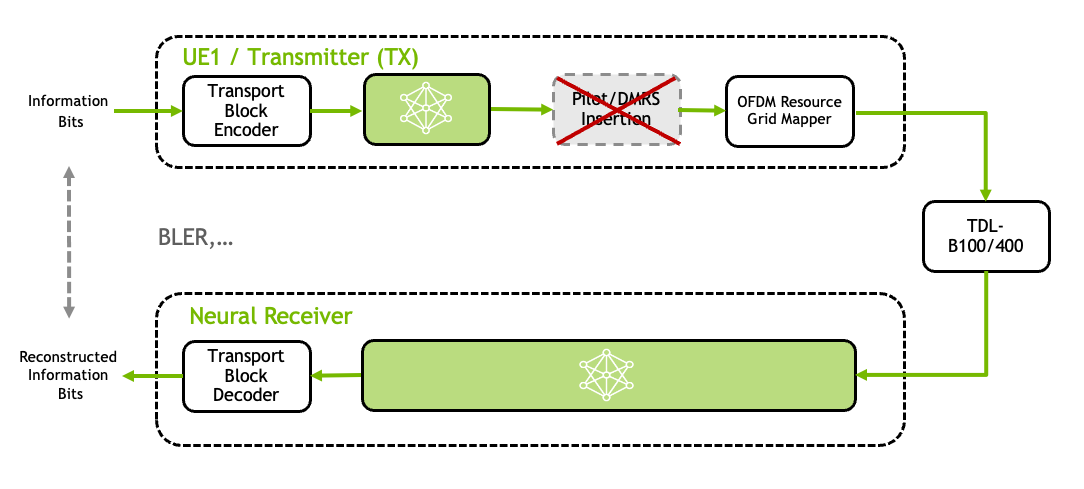

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Background Information](#Background-Information)
    - [Key Enabler 1: Custom Constellations](#Key-Enabler-1:-Custom-Constellations)    
    - [Key Enabler 2: DMRS-free Slot Configuration](#Key-Enabler-2-DMRS-free-slot-configuration)
    - [Key Enabler 3: Neural Receiver](#Key-Enabler-3:-Neural-Receiver)
* [Training](#Training)
* [Intuitive Interpretation of Pilotless Communications](#Intuitive-Interpretation-of-Pilotless-Communications)
* [Performance Evaluation](#Performance-Evaluation)
* [Outlook](#Outlook)
* [References](#References)






## GPU Configuration and Imports

In [1]:
# import relevant packages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress tf warnings

gpu_num = 0 # Number of the GPU to be used
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

import sys
sys.path.append('../') # to access all relevant repo files

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from utils import E2E_Model, Parameters, load_weights, plot_results, plot_gp
import numpy as np

Number of GPUs available : 2
Only GPU number 0 used.


## Background Information

The core idea of end-to-end learning [[3]](#references) is to jointly train the transmitter and receiver with respect to a single end-to-end performance metric. This metric can be the bit-error-rate (BER) or a differentiable proxy thereof, such as the binary-cross-entropy (BCE) loss.

The scalability and configurability of the approach in [[3]](#references) remains an unsolved research problem. Therefore, [[1]](#references) proposes an end-to-end learning scheme where only the QAM symbols are learned (denoted as *custom constellations*). The main benefit of this scheme is that the NRX can operate without the need for any additional DMRS pilots. As a result, the BLER performance of the system is similar to a classical baseline with 5G NR compliant DMRS. However, the *goodput* (i.e., the successfully transmitted payload bits per occupied resource element) can outperform the classical baseline. 

An important aspect for training such a system is the so-called *missing channel gradient* [[4]](#references). This means gradient descent-based training requires a differentiable channel model (and transceiver signal processing chain). Alternatively, concepts from reinforcement learning can be applied to avoid the need for a channel gradient [[5]](#references).
For an example implementation of RL-based training, see the tutorial [End-to-end learning with Autoencoders](https://nvlabs.github.io/sionna/examples/Autoencoder.html).
This training strategy could be obviously combined with the following experiments.

Let us now have a detailed look at the key ideas for the end-to-end learning system.

### Key Enabler 1: Custom Constellations

We initialize the transmitter with a *classical* 16-QAM modulation using Gray labeling as defined in the 5G NR standard.

Evaluating the first 2 port sets.


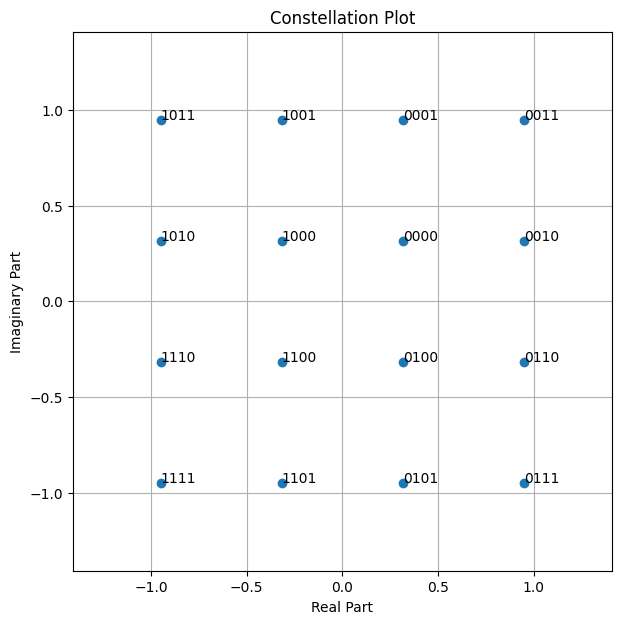

In [2]:
# load baseline without custom constellations
sys_parameters_nrx = Parameters(config_name="e2e_baseline.cfg",
                                training=True,
                                system='nrx')

# and plot the baseline constellations
sys_parameters_nrx.transmitters[0]._mapper.constellation.show();

However, during training, we consider the constellation points as trainable parameters (i.e., the points are treated as if they were weights of a neural network). Gradient descent-based training then finds a new non-uniform custom constellation.

Note that we impose a power constraint such that the resulting constellation has unit power.

Let’s have a look at the custom constellation after training.

Evaluating the first 1 port sets.
Activating trainable custom constellations.
Masking pilots for pilotless communications.


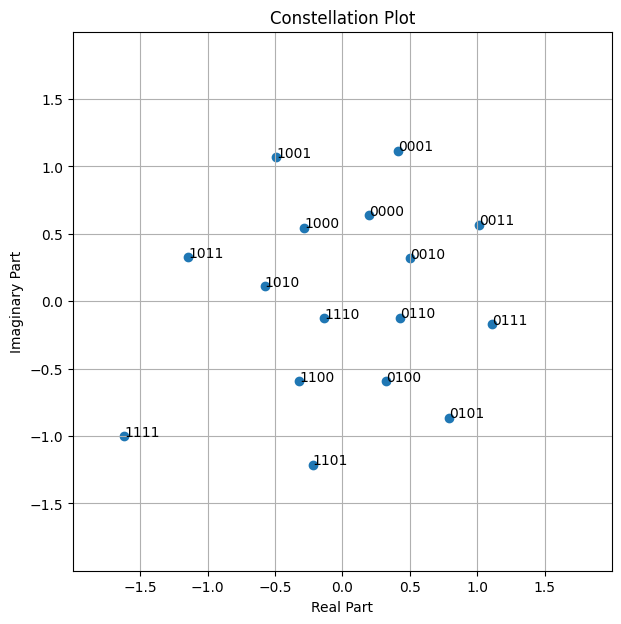

In [3]:
# load baseline without custom constellations
sys_parameters_e2e = Parameters(config_name="e2e_large.cfg",
                                training=True,
                                num_tx_eval=1,
                                system='nrx')

# and load weights (includes trainable constellations)
model_e2e = E2E_Model(sys_parameters_e2e, training=False, return_tb_status=False)

#run once to init weights (custom constellations are weights of the Keras model)
model_e2e(1,1.);
# and load the actual weights from file
filename = f'../weights/{sys_parameters_e2e.label}_weights'
load_weights(model_e2e, filename)

# and plot the custom constellations
model_e2e._transmitters[0]._mapper.constellation.show();

### Key Enabler 2: DMRS-free Slot Configuration

As mentioned above, a key advantage of pilotless communications is the data-aided channel estimation, which avoids the need for classical DMRS pilots and, thereby, reduces the piloting overhead.

As a baseline, we use a 5G NR configuration with 2 DMRS symbols (at positions 2 and 11) and the following DMRS parameters. For further background about DMRS, we refer to the [5G NR PUSCH tutorial](https://nvlabs.github.io/sionna/examples/5G_NR_PUSCH.html).

In [4]:
sys_parameters_nrx.transmitters[0]._pusch_configs[0].dmrs.show()

PUSCH DMRS Configuration
additional_position : 1
allowed_dmrs_ports : [0, 1]
beta : 1.0
cdm_groups : [0]
config_type : 1
deltas : [0]
dmrs_port_set : [0]
length : 1
n_id : None
n_scid : 1
num_cdm_groups_without_data : 1
type_a_position : 2
w_f : [[1]
 [1]]
w_t : [[1]
 [1]]



This leads to a pilot pattern as shown below.

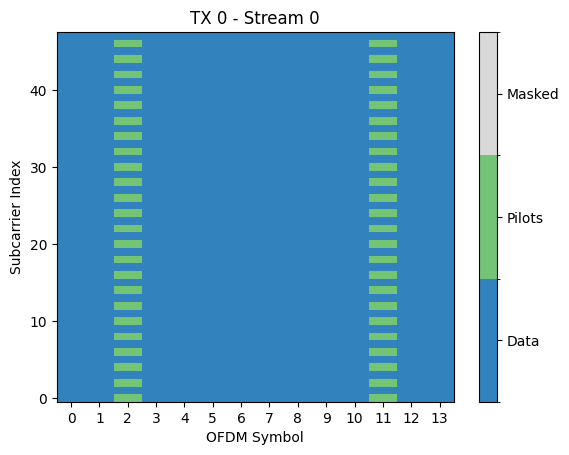

In [5]:
sys_parameters_nrx.transmitters[0].pilot_pattern.show(0);

For end-to-end learning, we select a minimal DMRS configuration in 5G and mask the remaining few pilots at the input of the receiver (i.e., they do not contribute to channel estimation). As such, the transmit signal remains 5G NR compliant, but the NRX does not benefit from the remaining few pilots. This ensures compatibility with our 5G NR over-the-air testbeds and simplifies proof-of-concept deployment. The price is a small piloting overhead that remains (which we exclude from the rate calculations).

Alternatively, one could implement a custom `PUSCHTransmitter` that does not transmit any DMRS pilots.

The exact DMRS configuration is given below:

In [6]:
sys_parameters_e2e.transmitters[0]._pusch_configs[0].dmrs.show()

PUSCH DMRS Configuration
additional_position : 0
allowed_dmrs_ports : [0, 1]
beta : 1.0
cdm_groups : [0]
config_type : 2
deltas : [0]
dmrs_port_set : [0]
length : 1
n_id : None
n_scid : 1
num_cdm_groups_without_data : 1
type_a_position : 2
w_f : [[1]
 [1]]
w_t : [[1]
 [1]]



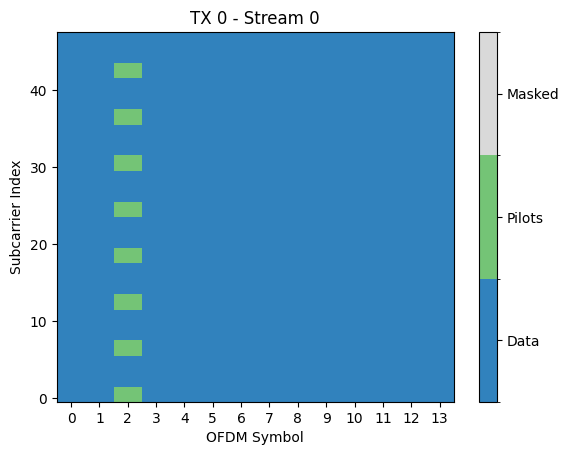

In [7]:
sys_parameters_e2e.transmitters[0].pilot_pattern.show(0);

We would like to emphasize again, that the remaining pilots are **masked** at the input of the neural receiver when using custom constellations
and that we opt for this "minimal DMRS configuration & masking of remaining pilots" to keep the required changes to the transmitter minimal.
For practical deployment in beyond-5G systems, one would need to implement a *DMRS-free* transmitter mode which is currently not available in the 5G standard.

### Key Enabler 3: Neural Receiver

We use the same neural receiver architecture as before; the only difference is that we mask the DMRS positions in the input signal to the neural receiver. This also implies that no initial least-square (LS) channel estimation can be provided. This can be activated by the three parameters in the `config`:
- `initial_chest = None` deactivates the initial channel estimator
- `custom_constellation = True` activates the trainable transmitter
- `mask_pilots = True` masks DMRS positions for end-to-end experiments

Please note that the end-to-end experiments are for a single-user setup. Thus, the stage combining part (see [NRX architecture notebook](nrx_architecture.ipynb)) is not in use. The neural network boils down to a similar architecture as used in the [end-to-end learning with autoencoders tutorial](https://nvlabs.github.io/sionna/examples/Autoencoder.html).
This also implies that the multi-user inference cancellation block is not required. The inference of the symbol-wise MLPs is not used and the computational complexity of the receiver is different when compared to the multi-user architecture (though the number of weights is much larger).

We empirically observe that the NRX requires more trainable weights when compared to the NRX with pilots and *classical* QAM modulation. Intuitively, the task of pilotless channel estimation is more complex to learn than processing slots with DMRS pilots (and initial least-square (LS) channel estimations).

In [8]:
model_e2e.summary()

Model: "e2e__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source (BinarySourc  multiple                  0         
 e)                                                              
                                                                 
 pusch_transmitter_1 (PUSCH  multiple                  32        
 Transmitter)                                                    
                                                                 
 ofdm_channel_1 (OFDMChanne  multiple                  0         
 l)                                                              
                                                                 
 neural_pusch_receiver (Neu  multiple                  539446    
 ralPUSCHReceiver)                                               
                                                                 
Total params: 539478 (2.06 MB)
Trainable params: 539478 

The model summary now also shows trainable parameters in the transmitter. In this case, we have 32 real-valued parameters which represent the real/imaginary parts of the custom 16-QAM constellation.

## Training

Training can be done with the same training loop as used for the NRX training. The training schedule in the config file is defined via the  `training_schedule`. One could also implement site-specific training to optimize the constellations for a specific environment, however, this is not done in the current experiments.

We set the custom constellations as trainable during the first gradient descent iterations and then finetune only the receiver weights during a second training phase. This avoids fluctuations towards the end and the training convergence of the transmitter weights is relatively fast.

A few remarks:
- As mentioned above, gradients with respect to the transmitter weights are required for end-to-end learning. This is straightforward when using the Sionna transceiver and channel components as it benefits from TensorFlow's autograd capability. However, when training with the actual physical channel in-the-loop, this becomes challenging. We train the system offline using channel models and avoid this issue.
- Contrary to the NRX example, training is done for a very narrow SNR region. In practice, one could think of different custom constellations per MCS scheme (trained offline). Alternatively, [[6]](#references) shows how to implement SNR-dependent custom constellations.
- The constellations are trained for the 3GPP `TDL-C300` channel model and evaluated for the `TDL-B100` channel model to avoid overfitting of the receiver to a specific channel model. One could possibly combine the training with site-specific channel models (by using ray tracing) to optimize for a specific environment. Training on a more universal `UMi` channel model is challenging as the effective SNR range during training has a larger variation (see comment about narrow SNR above).
- It can be beneficial to first train the NRX with *classical* QAM constellations and enable trainable custom constellations after some initial training iterations.

## Intuitive Interpretation of Pilotless Communications

Explaining the exact behavior of custom constellations in combination with neural receivers is challenging due to the *black-box* character of neural networks.
However, we now setup a simple experiment to get an intuition how the (inherent) channel estimation works.

Remember the learned custom constellations from above:

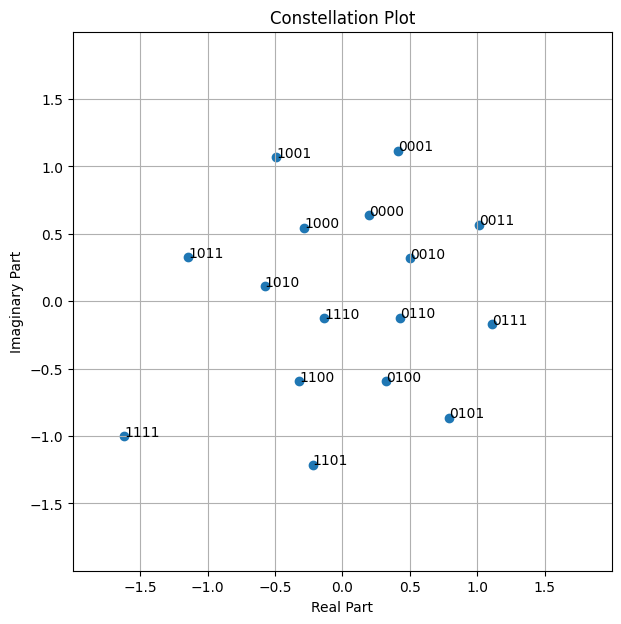

In [9]:
model_e2e._transmitters[0]._mapper.constellation.show();

Our intuition is that there is one symbol that acts as "anchor" for channel estimation as it stands out of the remaining symbols. 
The remaining constellation points follow the expected behaviour from a non-uniform geometric shapping.

Please note that the occurrence of such a strong symbol is reproducible, while the labeling is mostly random and depends on the exact training seed etc.
It also strongly depends on the training SNR and does not occur if channel estimates are provided. Intuitively, gradient-descent finds the best tradeoff between maximizing the information rate of the constellation and the required piloting overhead for a specific system configuration.

As we have trained the NRX with `double_readout` functionality, i.e., the NRX returns channel estimates. We can also visualize the result of channel estimation.
Keep in mind that the NRX has not seen any *classical* pilot for channel estimation in this setup.

We keep the transmitted slot fixed in the following experiment but average over many channel realizations.

In [10]:
eps = 1e-6
def eval_channel_estimator(batch_size, num_trials, ebno_db, excl_sym_idx):
    no = 10**(-ebno_db/10) # e2e learning uses Es/No

    # draw random payload bits
    b, _, _, _, _ = model_e2e(1, 0., output_nrx_h_hat=True) # dummy SNR

    # and generate fixed slot
    x = model_e2e._transmitters[0](b)

    # exclude symbols from the transmit alphabet
    x_np = x.numpy() # numpy allows easier indexing

    # indices of transmitted symbols
    incl_sym_idx = np.setdiff1d(np.arange(len(model_e2e._transmitters[0]._mapper.constellation.points)),
                        excl_sym_idx)
    for excl_idx in excl_sym_idx:
        c = model_e2e._transmitters[0]._mapper.constellation.points[excl_idx]
        #find all indices of occurence in slot
        idx = np.where(np.abs(x_np[0,0,0,...]-c/np.sqrt(2))<eps)
        # and replace by random non-excluded symbol
        for i,j in zip(idx[0], idx[1]):
            # sample random alternative symbol from avaiable list
            idx = incl_sym_idx[np.random.randint(low=0, high=len(incl_sym_idx))]
            x_np[:,:,:,i,j] = model_e2e._transmitters[0]._mapper.constellation.points[idx]/np.sqrt(2)
    x = tf.constant(x_np)

    # and repeat the same slot over the entire batch
    x = tf.tile(x,(batch_size,1,1,1,1,)) # duplicate data
    # single-user only
    active_dmrs = tf.ones((batch_size,1))
    mcs_ue_mask = tf.ones((batch_size,1,1))

    # average over many Monte Carlo trials
    loss = 0
    for it in range(num_trials):
        print(f"Progress: {it}/{num_trials}", end="\r")
        # draw new channel realization
        y, h = model_e2e._channel([x, no])
        # pre-process ground truth channel estimates
        h = model_e2e._receiver.preprocess_channel_ground_truth(h)

        # run NRX and access channel estimation
        _, h_hat, _, _ = model_e2e._receiver((y, active_dmrs), [0], mcs_ue_mask_eval=mcs_ue_mask)

        # and evaluate MSE loss between channel estimates and ground truth
        loss += tf.reduce_mean(tf.abs((h_hat - h))**2, axis=(0,-1))

    loss /= num_trials
    print("") #overwrite \r
    return loss, x


In [11]:
num_trials = 10 # average over many Monte Carlo trials
batch_size = 1000

ebno_db = 6
excl_sym_idx = [] # use all 16 custom constellations

# run evaluation
loss, x = eval_channel_estimator(batch_size, num_trials, ebno_db, excl_sym_idx)

print(f"Channel Estimation MSE: {10*np.log10(tf.reduce_mean(loss).numpy()):.2f} dB")

Progress: 9/10
Channel Estimation MSE: -17.52 dB


First, let us have a look at the transmitted slot used for this experiment. As can be seen, the *anchor* symbol (yellow dots) occurs with probability 1/16 and depends on the random payload bits.
This changes for every slot and is unknown to the NRX receiver. However, we have fixed this slot to be transmitted for all Monte Carlo iterations.

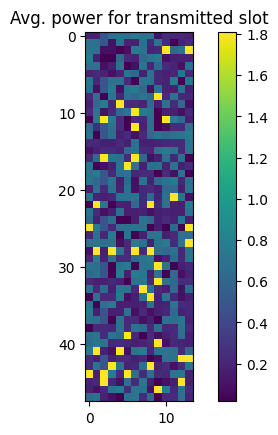

In [12]:
plt.imshow(tf.abs(tf.transpose(x,(0,1,2,4,3))**2)[0,0,0,...]);
plt.title("Avg. power for transmitted slot");
plt.colorbar();

However, when looking at the channel estimation error per resource element, we
can see that the MSE is relatively small around these anchor points.

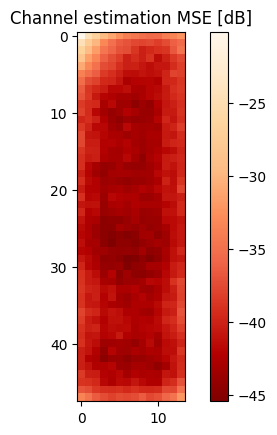

In [13]:
# and visualize the average error
plt.figure()
plt.imshow(10*np.log((loss[0,...]).numpy()),cmap="OrRd_r");
plt.title("Channel estimation MSE [dB]");
plt.colorbar();

We now extend the experiment and evaluate the channel estimation error again, but now we artificially exclude specific symbols from the constellation.
This is equivalent to removing the occurrence of the corresponding bit labels of the symbol from the (encoded) payload bit sequence.

In classical systems, this should not have a significant impact on the overall performance (besides a minor shift in transmit power depending on which QAM symbol is removed).

*Remark:* one can also see white spots in the channel estimation error plots at OFDM symbol 2. This is an artefact from the masked pilots at the receiver.

In [14]:
excl_sym_idx = [0] # remove first symbol with label 0000

# run evalaution
loss, x = eval_channel_estimator(batch_size, num_trials, ebno_db, excl_sym_idx)

print(f"MSE: {10*np.log10(tf.reduce_mean(loss).numpy()):.2f} dB")

Progress: 9/10
MSE: -17.33 dB


As can be seen, the MSE loss has not changed significantly.

Let us now exclude the "anchor" symbol, i.e., the symbol with strongest transmit power.

In [15]:
# remove first symbol with highest power
excl_sym_idx = [tf.argmax(tf.abs(model_e2e._transmitters[0]._mapper.constellation.points)**2).numpy()]

print(f"Excluding symbol with index {excl_sym_idx}")

# re-run evalaution
loss, x = eval_channel_estimator(batch_size, num_trials, ebno_db, excl_sym_idx)

print(f"Mean loss: {10*np.log10(tf.reduce_mean(loss).numpy()):.2f} dB")

Excluding symbol with index [15]
Progress: 9/10
Mean loss: -5.40 dB


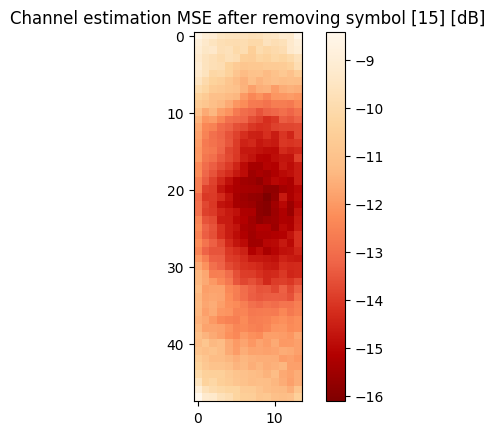

In [16]:
# and visualize the average error
plt.figure()
plt.imshow(10*np.log((loss[0,...]).numpy()),cmap="OrRd_r");
plt.title(f"Channel estimation MSE after removing symbol {excl_sym_idx} [dB]");
plt.colorbar();

As expected, when excluding the *anchor* symbol, we observe a significantly
larger channel estimation error.

Let us now complete this comparison by evaluating MSE when excluding each of the custom constellation symbols.

In [17]:
# num constellation symbols
M = len(model_e2e._transmitters[0]._mapper.constellation.points)
avg_loss = np.zeros((M,))
for i in range(M):
    excl_sym_idx = [i] # remove first symbol with label 0000

    # run evalaution
    loss, x = eval_channel_estimator(batch_size, num_trials, ebno_db, excl_sym_idx)
    avg_loss[i] = 10*np.log10(tf.reduce_mean(loss).numpy())
    print(f"Removing symbol {i}; Channel estimation MSE: {avg_loss[i]:.2f} dB")

Progress: 9/10
Removing symbol 0; Channel estimation MSE: -17.71 dB
Progress: 9/10
Removing symbol 1; Channel estimation MSE: -17.58 dB
Progress: 9/10
Removing symbol 2; Channel estimation MSE: -17.54 dB
Progress: 9/10
Removing symbol 3; Channel estimation MSE: -17.57 dB
Progress: 9/10
Removing symbol 4; Channel estimation MSE: -17.73 dB
Progress: 9/10
Removing symbol 5; Channel estimation MSE: -17.81 dB
Progress: 9/10
Removing symbol 6; Channel estimation MSE: -17.44 dB
Progress: 9/10
Removing symbol 7; Channel estimation MSE: -17.61 dB
Progress: 9/10
Removing symbol 8; Channel estimation MSE: -17.52 dB
Progress: 9/10
Removing symbol 9; Channel estimation MSE: -17.53 dB
Progress: 9/10
Removing symbol 10; Channel estimation MSE: -17.63 dB
Progress: 9/10
Removing symbol 11; Channel estimation MSE: -17.58 dB
Progress: 9/10
Removing symbol 12; Channel estimation MSE: -17.67 dB
Progress: 9/10
Removing symbol 13; Channel estimation MSE: -17.58 dB
Progress: 9/10
Removing symbol 14; Channel e

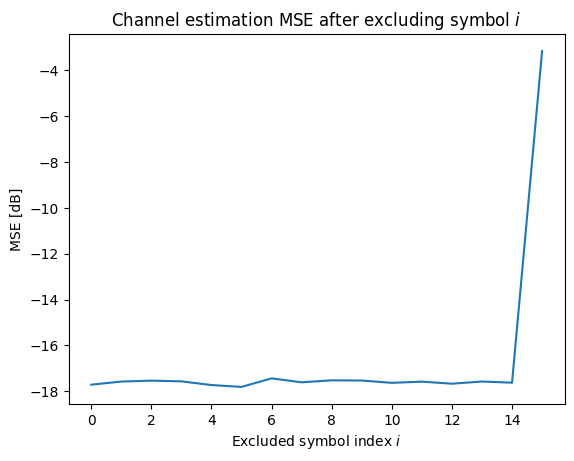

In [18]:
plt.plot(np.arange(M), avg_loss)
plt.title("Channel estimation MSE after excluding symbol $i$");
plt.xlabel("Excluded symbol index $i$");
plt.ylabel("MSE [dB]");

As expected, we observe a significantly larger channel estimation error when excluding the *anchor* symbol, compared to excluding any other symbol. We conclude that this *anchor* symbol has a specific contribution to the implicit channel estimation carried out by the neural receiver.

## Performance Evaluation

We now evaluate the TBLER of the end-to-end system after training. As we are comparing systems with different communication rates due to reduced DMRS piloting overhead, there are a few important details:
- For rate-adjusted SNR plots, we account for the different piloting overhead (see [ebno2db](https://nvlabs.github.io/sionna/api/utils.html#ebnodb2no))
- For the goodput calculation, we ignore the masked pilots as they do not add any information to the receiver (as if they were not transmitted)

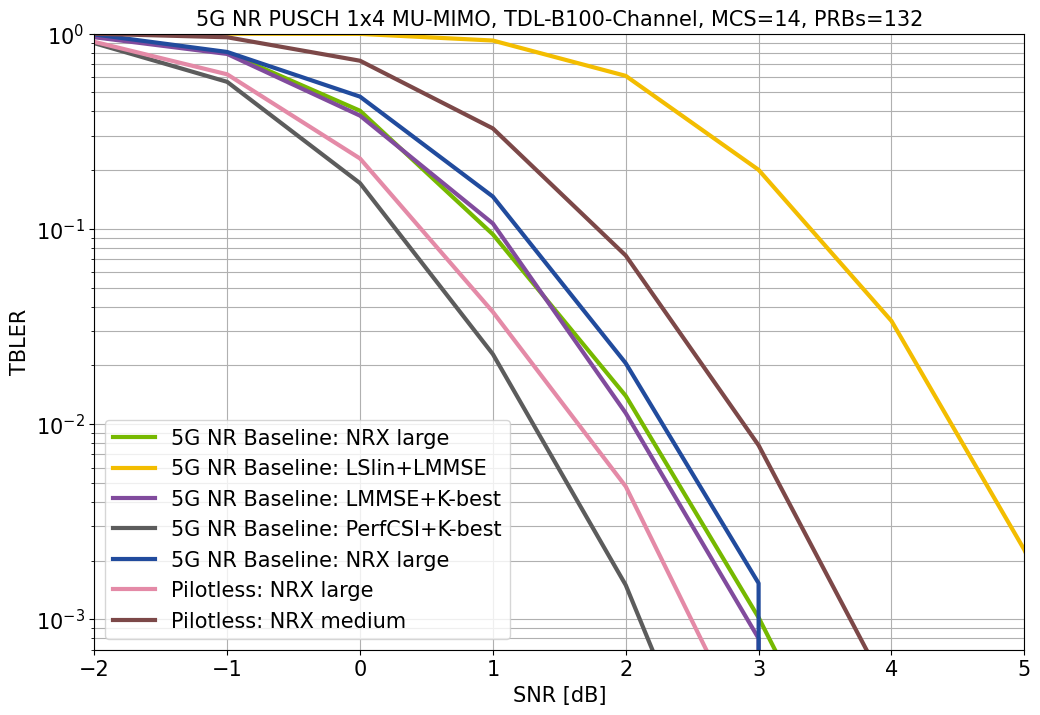

In [19]:
num_tx_eval = 1 # depends on what has been evaluated in evaluate.py before
xlim = [-2,5]

# We use the same config and results as used in all other notebooks as baseline
fig = plot_results(config_name="e2e_baseline.cfg", num_tx_eval=num_tx_eval, sim_idx=(0,1,2,3), xlim=xlim, ylim=[7e-4,1],
                   labels=["5G NR Baseline: NRX large","5G NR Baseline: LSlin+LMMSE","5G NR Baseline: LMMSE+K-best", "5G NR Baseline: PerfCSI+K-best",]);

# Remark: NRX large has small rate_shift due to different
fig = plot_results(fig=fig, config_name="nrx_large.cfg", num_tx_eval=num_tx_eval,
             xlim=xlim, ylim=[7e-4,1], color_offset=4, labels=["5G NR Baseline: NRX large"]);

# and let's add end-to-end learning results
fig = plot_results(fig=fig, config_name="e2e_large.cfg", num_tx_eval=num_tx_eval,
             xlim=xlim, ylim=[7e-4,1], color_offset=5, labels=["Pilotless: NRX large"]);

fig = plot_results(fig=fig, config_name="e2e_rt.cfg", num_tx_eval=num_tx_eval,
             xlim=xlim, ylim=[7e-4,1], color_offset=6, labels=["Pilotless: NRX medium"]);


As can be seen, the achieved performance of the system outperformsthe 5G NR baseline system with LMMSE-based channel estimation and K-best detection. Further, the information rates of the compared systems are different as the end-to-end learning solution does not require the DMRS piloting overhead. Thus, it operates at a higher communication rate per occupied resource element.

To have a more fair comparison, we evaluate the *goodput* of the system:
$$G = (1-P_\text{BLER}) * N_\text{payload} / N_\text{REs} $$
where $P_\text{BLER}$ is the BLER, $N_\text{payload}$ the number of transmitted payload bits, and $N_\text{REs}$ the number of occupied resource elements.

This metric tells us the number of successfully transmitted payload bits per occupied resource element.

Evaluating the first 1 port sets.
------------------------------
Total number of REs: 22176
Total number of payload bits: 44040
Number of pilots: 1584
Number of empty pilots: 0
Goodput w. pilots: [0.06619769 0.39718615 1.1852539  1.79961027 1.95818652 1.98389847
 1.98583806 1.98593074 1.98593074] [info. bits / RE]
Goodput w.o. pilots: [0.07128982 0.42773893 1.27642728 1.93804183 2.10881626 2.13650604
 2.13859483 2.13869464 2.13869464] [info. bits / RE]
------------------------------
Total number of REs: 22176
Total number of payload bits: 44040
Number of pilots: 1584
Number of empty pilots: 0
Goodput w. pilots: [0.         0.         0.00389398 0.15329992 0.77782287 1.58716845
 1.91879502 1.98141212 1.98577186] [info. bits / RE]
Goodput w.o. pilots: [0.         0.         0.00419352 0.16509222 0.8376554  1.70925833
 2.06639464 2.13382844 2.13852354] [info. bits / RE]
------------------------------
Total number of REs: 22176
Total number of payload bits: 44040
Number of pilots: 1584
Num

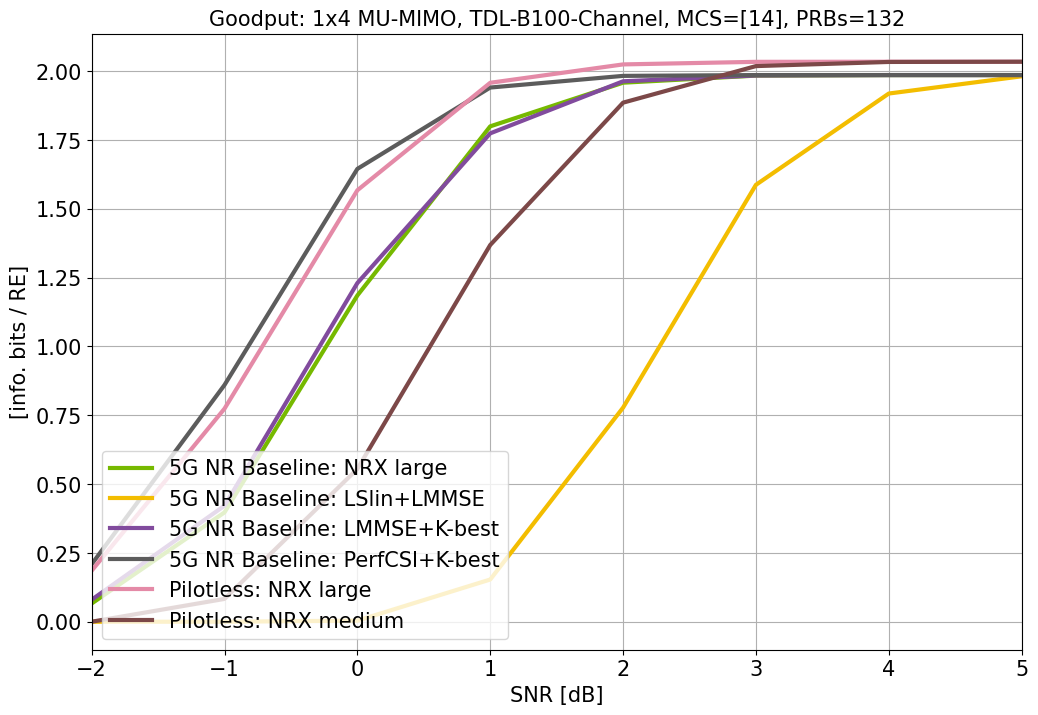

In [20]:
verbose = True # print additional info during goodput calculation
xlim = [-2,5]

fig = plot_gp(config_name="e2e_baseline.cfg", sim_idx=(0,1,2,3), xlim=xlim,
              verbose=verbose, num_tx_eval=1,
              labels=["5G NR Baseline: NRX large","5G NR Baseline: LSlin+LMMSE","5G NR Baseline: LMMSE+K-best", "5G NR Baseline: PerfCSI+K-best",]);


fig = plot_gp(config_name="e2e_large.cfg", sim_idx=0, num_tx_eval=1,
        color_offset=5, fig=fig, xlim=xlim, verbose=verbose,
        labels=["Pilotless: NRX large"]);

fig = plot_gp(config_name="e2e_rt.cfg", sim_idx=0, num_tx_eval=1,
        color_offset=6, fig=fig, xlim=xlim, verbose=verbose,
        labels=["Pilotless: NRX medium"]);

As can be seen, the pilotless communications scheme outperforms the traditional scheme in terms of goodput.
However, we do not want to oversell these results because many more details need to be considered.
For example the end-to-end model was initially trained for a specific `TDL-C`
channel model (as explained above), while the 5G NR baseline NRX is trained on
the more general `UMi´ channel model. Another aspect are hardware constraints
such as the peak-to-average power ratio (PAPR) of the learned constellation. One
should also keep in mid that DMRS symbols might be used for other purposes that
channel estimation, e.g., synchronization. However, we think it is an interesting research avenue full of exciting challenges and opportunities. 

### Hardware Impairments: CFO compensation

The neural receiver can learn to compensate for effects that have been included in the training process.
As an example, we have implemented the capability to simulate a carrier frequency offset (CFO) in the end-to-end model.

It can be activated by setting the 
`cfo_offset_ppm` parameter (in parts per million) in the `config` file. During training, the CFO is then randomly sampled in the interval `[-cfo_offset_ppm, cfo_offset_ppm]`. For evaluation, a fixed CFO can be set via the `cfo_offset_ppm_eval` parameter.

It can be shown that the BLER performance of the end-to-end system without CFO-aware training is degraded once CFO occurs. However,
if considered already during training, the NRX remains robust w.r.t. CFO. 


## Outlook

In this tutorial, we have seen how the 5G NR PUSCH could be extended by a pilotless communication scheme using custom constellations and end-to-end learning.
Besides a neural network-based receiver, the only required changes are custom constellations and the introduction of a *DMRS-free* slot configuration.

It remains an open research challenge to find scalable multi-user MIMO solutions that allow scheduling multiple users on different DMRS ports with custom constellations. Further, adaptive re-training and online learning promise interesting research opportunities. One example is the combination with [site-specific training](site_specific_neural_receivers.ipynb) where the custom constellation could be adapted to a specific environment.

## References

[1] F. Aït Aoudia and J. Hoydis, "[End-to-end Learning for OFDM: From Neural Receivers to Pilotless Communication](https://arxiv.org/abs/2009.05261)," IEEE Trans on Wireless Commun., 2021.

[2] D. Korpi, M. Honkala, and J. Huttunen, "[Deep Learning-Based Pilotless Spatial Multiplexing](https://arxiv.org/abs/2312.05158)," arXiv preprint arXiv:2312.05158, 2023.

[3] T. O’Shea and J. Hoydis, “[An Introduction to Deep Learning for the Physical Layer](https://arxiv.org/abs/1702.00832),” IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017.

[4] S. Dörner, S, Cammerer, J. Hoydis, and S. ten Brink, "[Deep Learning based Communication Over the Air](https://arxiv.org/abs/1707.03384)," IEEE Journal of Selected Topics in Signal Processing, vol. 12, no. 1, 2017.

[5] F. Aït Aoudia and J. Hoydis, "[Model-free Training of End-to-end Communication Systems](https://arxiv.org/abs/1812.05929)," IEEE Journal on
Selected Areas in Communications, vol. 37, no. 11, 2019.

[6] S. Cammerer, F. Aït Aoudia, S. Dörner, M. Stark, J. Hoydis, and S. ten Brink, "[Trainable Communication Systems: Concepts and Prototype](https://arxiv.org/abs/1911.13055)," IEEE Transactions on Communications, vol. 68, no. 9, 2020.